In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn


import pickle
import os
import time

if not os.path.exists('models'):
    os.makedirs('models')

if not os.path.exists('results'):
    os.makedirs('results')

if not os.path.exists('data'):
    os.makedirs('data')


### `Loading the dataset`

This is obtained from the pytorch documentation https://pytorch.org/hub/pytorch_vision_alexnet/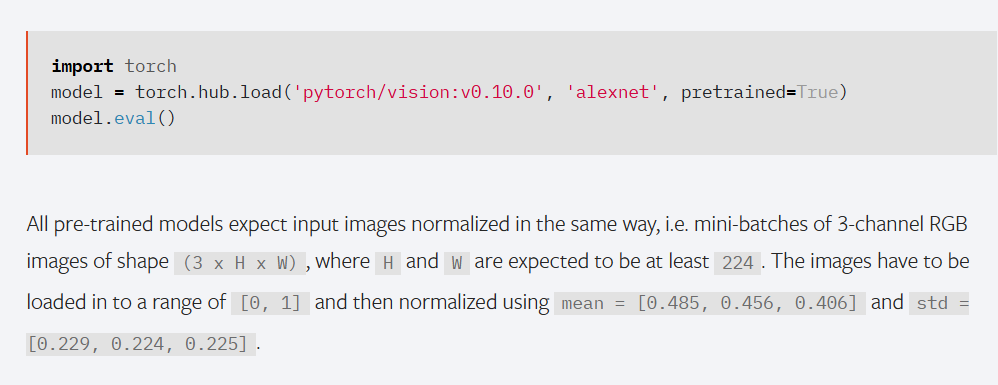

In [24]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [25]:
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.3235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


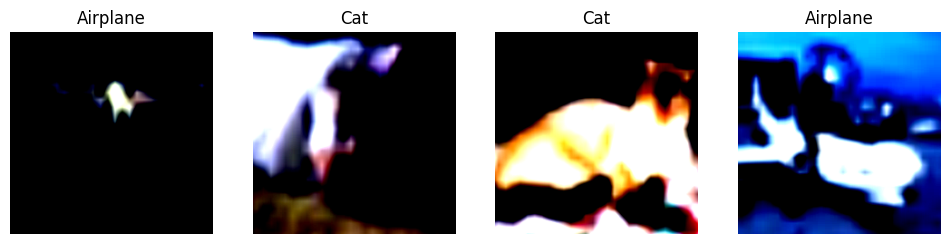

In [26]:
# Get the first 4 images 
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(images[i].numpy().transpose((1, 2, 0)))
    axes[i].set_title(classes[labels[i]])
    axes[i].axis('off')
plt.show()

### `Model Building`

In [ ]:
alexnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
alexnet_model.eval()

In [28]:
# Modify the classifier to match CIFAR-10 output
alexnet_model.classifier[1] = nn.Linear(9216,4096)
alexnet_model.classifier[4] = nn.Linear(4096,512)
alexnet_model.classifier[6] = nn.Linear(512,10)
alexnet_model.eval()


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [30]:
alexnet_model.to(device)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet_model.parameters(), lr=0.001, momentum=0.7)

In [32]:
train_loss = []
train_accuracy = []
epoch_time = []

for epoch in range(4):  # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = alexnet_model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # print statistics
        running_loss += loss.item()
        if i % 4000 == 3999:    # print every 4000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 4000))
            print('Time:', time.time() - start_time)
            running_loss = 0.0
    
    # Calculate epoch metrics
    end_time = time.time()
    epoch_time.append(end_time - start_time)
    
    # Calculate average loss for the epoch
    epoch_loss = 0.0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = alexnet_model(images)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(trainloader)
    train_loss.append(avg_loss)
    
    # Calculate accuracy for the epoch
    accuracy = 100 * correct / total
    train_accuracy.append(accuracy)
    
    print(f'Epoch {epoch+1} completed. Loss: {avg_loss:.3f}, Accuracy: {accuracy:.2f}%, Time: {epoch_time[-1]:.2f}s')

print('Finished Training of AlexNet')

[1,  4000] loss: 0.877
Time: 76.91796064376831
[1,  8000] loss: 0.605
Time: 144.13765788078308
[1, 12000] loss: 0.516
Time: 211.71481919288635
Epoch 1 completed. Loss: 0.381, Accuracy: 77.18%, Time: 220.83s
[2,  4000] loss: 0.379
Time: 77.75605392456055
[2,  8000] loss: 0.360
Time: 147.35340213775635
[2, 12000] loss: 0.351
Time: 215.85006093978882
Epoch 2 completed. Loss: 0.257, Accuracy: 87.28%, Time: 225.12s
[3,  4000] loss: 0.213
Time: 77.58686685562134
[3,  8000] loss: 0.225
Time: 146.68442511558533
[3, 12000] loss: 0.235
Time: 216.2773094177246
Epoch 3 completed. Loss: 0.140, Accuracy: 92.24%, Time: 225.53s
[4,  4000] loss: 0.124
Time: 79.40027856826782
[4,  8000] loss: 0.134
Time: 147.11690068244934
[4, 12000] loss: 0.143
Time: 215.23536920547485
Epoch 4 completed. Loss: 0.132, Accuracy: 95.40%, Time: 224.33s
Finished Training of AlexNet


In [33]:
#Testing Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = alexnet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network : %.2f %%' % (100 * correct / total))

Accuracy of the network : 84.15 %


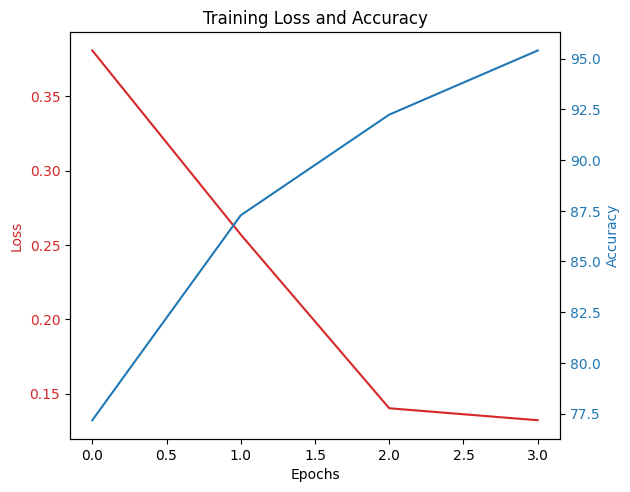

In [34]:
#Training accuracy/loss curves

def plot_loss_accuracy(train_loss, train_accuracy):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(train_loss, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)  
    ax2.plot(train_accuracy, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.title('Training Loss and Accuracy')
    plt.show()
plot_loss_accuracy(train_loss, train_accuracy)


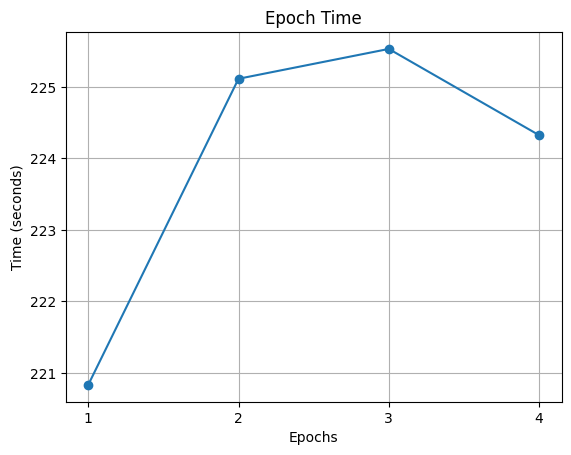

In [38]:
# plot the training time for each epoch where step size on the graph is 1 epoch
# and the y-axis is the time taken for each epoch in seconds
def plot_epoch_time(epoch_time):
    plt.plot(range(1, len(epoch_time) + 1), epoch_time, marker='o')
    plt.title('Epoch Time')
    plt.xlabel('Epochs')
    plt.ylabel('Time (seconds)')
    plt.xticks(range(1, len(epoch_time) + 1))
    plt.grid()
    plt.show()

plot_epoch_time(epoch_time)

In [39]:
#Save the training loss and accuracy and epoch time
with open(os.path.join('results', 'training_results_alexnet.pkl'), 'wb') as f:
    pickle.dump({'loss': train_loss, 'accuracy': train_accuracy, 'epoch_time': epoch_time}, f)


In [40]:
# Save the model architecture and weights
PATH = os.path.join(os.getcwd(),'models', 'alexnet_cifar10.pth')
torch.save(alexnet_model.state_dict(), PATH)
